# Preprocessing

[https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/](https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/)

## Imports

In [2]:
# !pip install pydicom

In [3]:
import os
import sys

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import cv2
import pydicom

## Install Kaggle API to download competition data

In [4]:
pip install -q kaggle

In [5]:
os.environ["KAGGLE_USERNAME"] = "zahedgolabi"
os.environ["KAGGLE_KEY"] = "0b422377139ea03759e743fe327354e8"

In [6]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [00:41<00:00, 110MB/s] 
100% 3.66G/3.66G [00:41<00:00, 95.7MB/s]


In [7]:
!unzip -q -o rsna-pneumonia-detection-challenge.zip -d datasets

## Train Test Data

In [8]:
labels = pd.read_csv("/content/datasets/stage_2_train_labels.csv")

In [9]:
labels.sample(4)

,patientId,x,y,width,height,Target
2070,2415c886-456c-447a-b418-bbf877ddefd1,205.0,234.0,149.0,233.0,1
3238,371e6626-7884-4232-9629-0220fe6e7172,16.0,3.0,375.0,416.0,1
9418,67311adb-0491-40b3-9938-17ac0aa61fb5,NaN,NaN,NaN,NaN,0
18790,b0502b9f-b85c-4cac-9e8f-325ed59315e0,231.0,502.0,173.0,178.0,1


In [10]:
len(labels)

30227

In [11]:
# remove duplicates
labels = labels.drop_duplicates("patientId")

In [12]:
len(labels)

26684

In [13]:
ROOT_PATH = Path("/content/datasets/stage_2_train_images/")
SAVE_PATH = Path("/content/Processed")

## Display some Images from Train

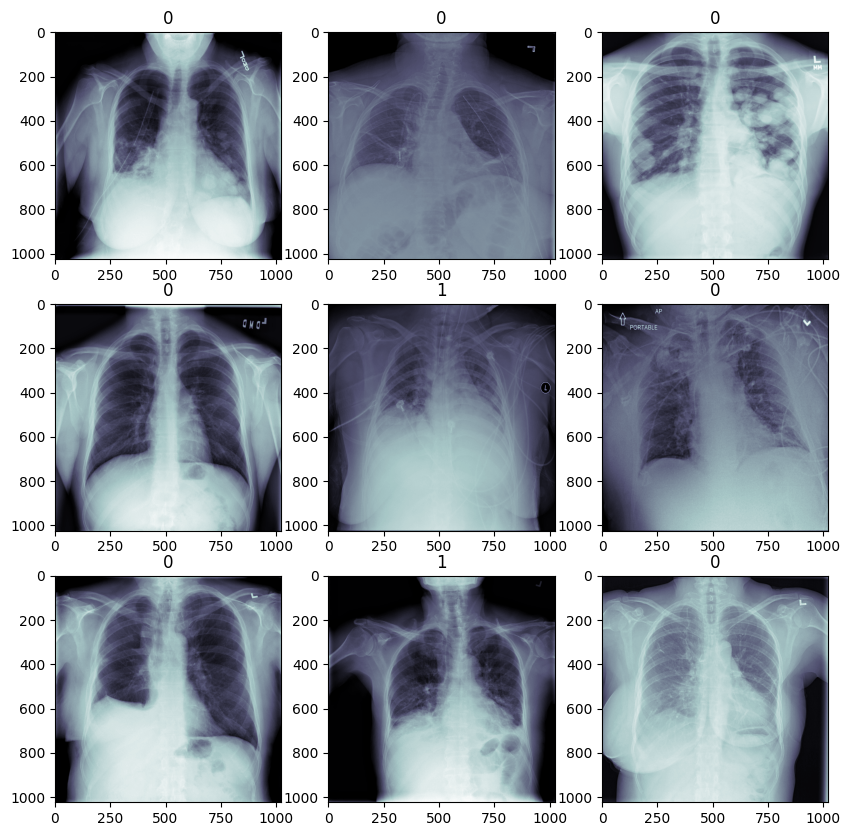

In [14]:
fig, axis = plt.subplots(3,3, figsize=(10,10))

counter = 0
for row in range(3):
  for column in range(3):

    patient_id = labels["patientId"].iloc[counter]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array

    label = labels["Target"].iloc[counter]

    axis[row][column].imshow(dcm, cmap="bone")
    axis[row][column].set_title(label)

    counter += 1

## Preprocessing

In [15]:
sums, sums_squared = 0, 0

for counter,patient_id in enumerate(tqdm(labels["patientId"])):

  patient_id = labels["patientId"].iloc[counter]
  dcm_path = ROOT_PATH/patient_id
  dcm_path = dcm_path.with_suffix(".dcm")
  # Normalize
  dcm = pydicom.read_file(dcm_path).pixel_array / 255

  # Resize
  dcm_array = cv2.resize(dcm, (224,224)).astype(np.float32)

  label = labels["Target"].iloc[counter]

  train_or_val = "train" if counter < 24000 else "val"

  current_save_path = SAVE_PATH/train_or_val/str(label)
  current_save_path.mkdir(parents=True, exist_ok=True)
  np.save(current_save_path/patient_id, dcm_array)

  normalizer = 224 * 224
  if train_or_val == "train":
    sums += np.sum(dcm_array) / normalizer
    sums_squared += (dcm_array ** 2).sum()  / normalizer




  0%|          | 0/26684 [00:00<?, ?it/s]

In [16]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [17]:
mean, std

(0.4903974349223022, 0.2479450236400053)

---

---

---

# Train Model

## Data Loading

In [19]:
# !pip install pytorch_lightning

## Imports

In [20]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

## Loading Data

In [21]:
def load_file(path):
  return np.load(path).astype(np.float32)

### Train Transformation

In [22]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))

])

### Val Transformation

In [24]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
])

### Load train dataset

In [25]:
train_dataset = torchvision.datasets.DatasetFolder("/content/Processed/train/", loader=load_file, extensions="npy", transform=train_transforms)

### Load val dataset

In [26]:
val_dataset = torchvision.datasets.DatasetFolder("/content/Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

## Display Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


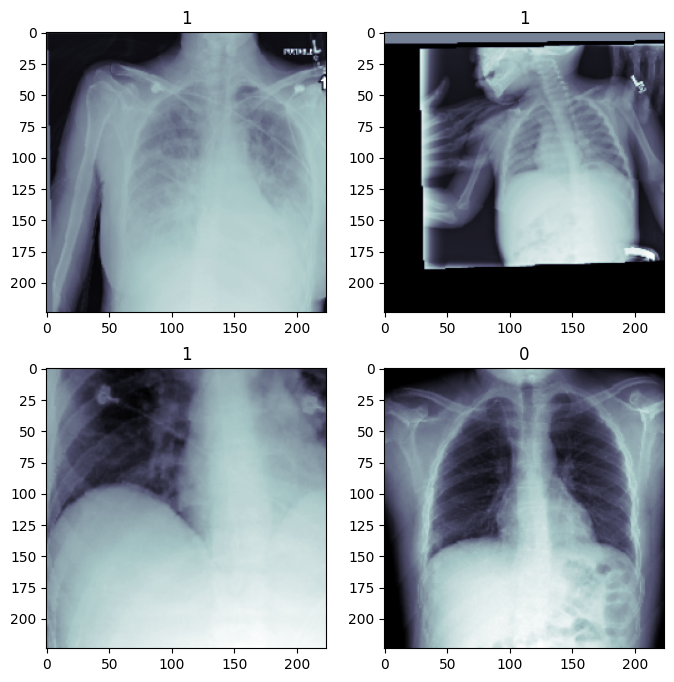

In [27]:
fig, axis = plt.subplots(2,2, figsize=(8,8))

for row in range(2):
  for column in range(2):
    random_index = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_index]
    axis[row][column].imshow(x_ray[0], cmap="bone")
    axis[row][column].set_title(label)

## Train Loader

In [28]:
batch_size = 64
num_workers = 6

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Val Loader

In [29]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

---

---

---

## Model Creation

### Resnet Model

In [31]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaModel(pl.LightningModule):

  def __init__(self):
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()


  def forward(self, data):
    pred = self.model(data)
    return pred
